# Notebook 3a: Modeling With ARIMA

Following my Data Cleaning and EDA notebook, I plan to explore the trends in the data and predict future trends using a few different models. For sentiment, comment count, and unique commenters, I plan to use ARIMA models to see if predicting future numbers is a viable endeavor. With these models, we can predict future participation and sentiment, regardless of the patch releases. While it isn't directly related to the problem at hand, it may be interesting to explore. 

ARIMA models are based on information that is correlated with itself over time, meaning that, for example, the number of unique commenters today is correlated with the number of commenters yesterday. We will be looking for stationarity, meaning that the the mean over time remains constant. To test for this we will be utilizing the augmented dicky fuller test and looking at the t-test and p values. 


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf, pacf

%matplotlib inline

Reading in my three dataframes

In [52]:
df_daily = pd.read_csv('../data/df_daily.csv', index_col = 'date')

In [53]:
df_daily.shape

(203, 37)

In [54]:
df_daily.isnull().sum().sum()

0

Changing the index to a datetime index. 

In [55]:
df_daily.index = pd.to_datetime(df_daily.index)

## ARIMA Sentiment Predictions

Splitting a train and test set for my arima model. 

In [56]:
df_daily.shape[0] * 3/4

152.25

In [57]:
train_compound = df_daily['compound'].iloc[0:152]
test_compound  = df_daily['compound'].iloc[152:]

Instantiating my ARIMA model and making predictions for train and test sets. For this instance, I am using a 2 0 2 model.

In [58]:
model = ARIMA(endog = train_compound,
              order = (2,0,2))
arima_2_0_2 = model.fit()

preds_train_compound = arima_2_0_2.predict(start = 1, end = 152)
preds_test_compound  = arima_2_0_2.predict(start = 152, end = 202)

/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


Examining RMSE compared to the mean's RMSE.

In [59]:
print('Train RMSE: ', mean_squared_error(train_compound, preds_train_compound)**(1/2))
print('Test RMSE: ',mean_squared_error(test_compound, preds_test_compound)**(1/2))
print('Mean RMSE: ', mean_squared_error(test_compound, [df_daily['compound'].mean() for i in range(len(test_compound))])**(1/2))

Train RMSE:  0.011007927198567415
Test RMSE:  0.0339136011810973
Mean RMSE:  0.026984277049076976


My training RMSE is slightly better than the mean RMSE, but my testing RMSE is slightly worse than the mean RMSE. This model isn't great at predicting future sentiment scores. We will look at the graph below. 

Setting the indicies as datetimes for the plots

In [60]:
train_compound.index = pd.to_datetime(train_compound.index)

In [61]:
test_compound.index = pd.to_datetime(test_compound.index)

In [62]:
adfuller(df_daily['compound'])

(-2.2608953347282723,
 0.1848902198672459,
 6,
 196,
 {'1%': -3.464161278384219,
  '5%': -2.876401960790147,
  '10%': -2.5746921001665974},
 -935.9940555173494)

In [63]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index = ['Test Statistic', 'p-value'])
    return dfoutput

In [64]:
interpret_dftest(adfuller(df_daily['compound']))

Test Statistic   -2.260895
p-value           0.184890
dtype: float64

My data is not stationary, as my p value is above .05, which means we fail to reject the null hypothesis.  I will plot the predictions below. 

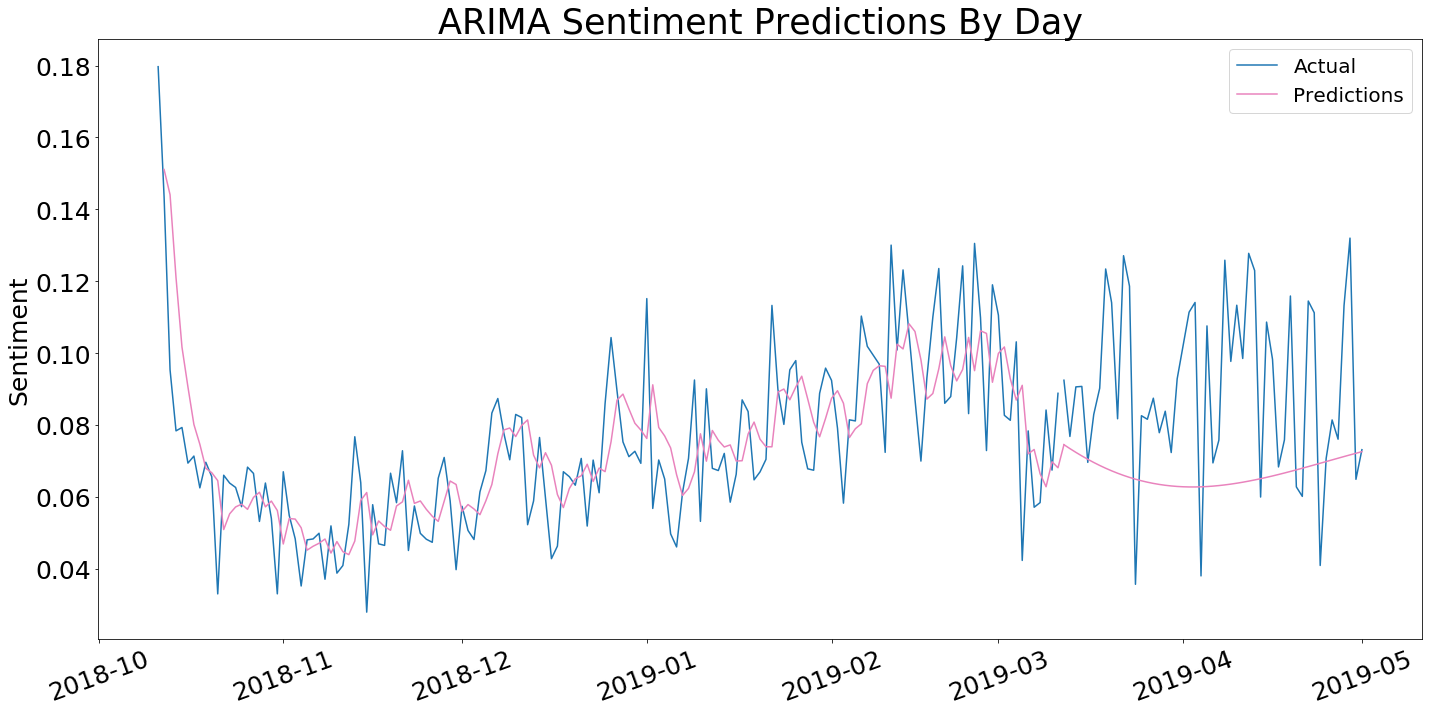

In [65]:
plt.figure(figsize = (20,10))
plt.plot(train_compound, color = 'C0')
plt.plot(preds_train_compound, color = '#E983BD')
plt.plot(test_compound, color = 'C0')
plt.plot(preds_test_compound, color = '#E983BD')

plt.title('ARIMA Sentiment Predictions By Day', fontsize = 35)
plt.xticks(fontsize = 25, rotation = 20)
plt.yticks(fontsize = 25)
plt.ylabel('Sentiment', fontsize = 25)
plt.tight_layout()
plt.legend(['Actual', 'Predictions'], fontsize = 20);
#plt.savefig('../plots/arima_2.png');

In the above graph, we can see that there isn't a whole lot of signal in the sentiment over time. My training set goes from 2018-10 to 2019-03, where my testing set starts. My model is struggling to fit on the training data, and when it hits the testing data, it predicts an upward swing, but isn't able to follow along with the seemingly random fluctations of the sentiment on a daily basis. As I mentioned above, it is predicting worse than it would have had it just predicted the mean. This just shows that predicting sentiment over time, even though it is stationary, isn't a viable strategy. This would suggest that perhaps taking user sentiment into account may not matter, as it is unpredictable, and users will react positively or negatively based on their personal state of mind, regardless of the fixes or updates that come out.

## ARIMA Comment Predictions

In [66]:
train_comment_count = df_daily['count_comments'].iloc[0:152]
test_comment_count  = df_daily['count_comments'].iloc[152:]

Instantiating another ARIMA model. This time, I am running a 3 0 1 model. 

In [67]:
model = ARIMA(endog = train_comment_count,
              order = (3,0,1))
arima_3_0_1 = model.fit()

preds_train_comment_count = arima_3_0_1.predict(start = 0, end = 151)
preds_test_comment_count  = arima_3_0_1.predict(start = 151, end = 201)

/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [68]:
print('Train RMSE: ', mean_squared_error(train_comment_count, preds_train_comment_count)**(1/2))
print('Test RMSE: ', mean_squared_error(test_comment_count, preds_test_comment_count)**(1/2))
print('Mean RMSE: ', mean_squared_error(test_comment_count, [df_daily['comment_count'].mean() for i in range(len(test_compound))])**(1/2))

Train RMSE:  1720.3188392529378
Test RMSE:  1612.2835194221004
Mean RMSE:  4687.260058264953


As we can see above, predicting the number of comments on a given day is more plausible than sentiment, because there is more of a trend to user activity. My training data fit nicely, and my testing data fit decently, as we can see that both of their RMSE scores are less than they would be if the model was simply predicting the mean, which is an improvement. 

In [69]:
df_daily['count_comments'].mean()

7023.320197044335

Changing the index to datetime for plotting.

In [70]:
train_comment_count.index = pd.to_datetime(train_comment_count.index)

In [71]:
test_comment_count.index = pd.to_datetime(test_comment_count.index)

In [72]:
interpret_dftest(adfuller(df_daily['count_comments']))

Test Statistic   -3.517364
p-value           0.007552
dtype: float64

My p value is less than .05, so we can reject the null hypothesis, meaning our data is stationary, and has a constant mean over time. 

In [73]:
df_daily['count_comments'].mean()

7023.320197044335

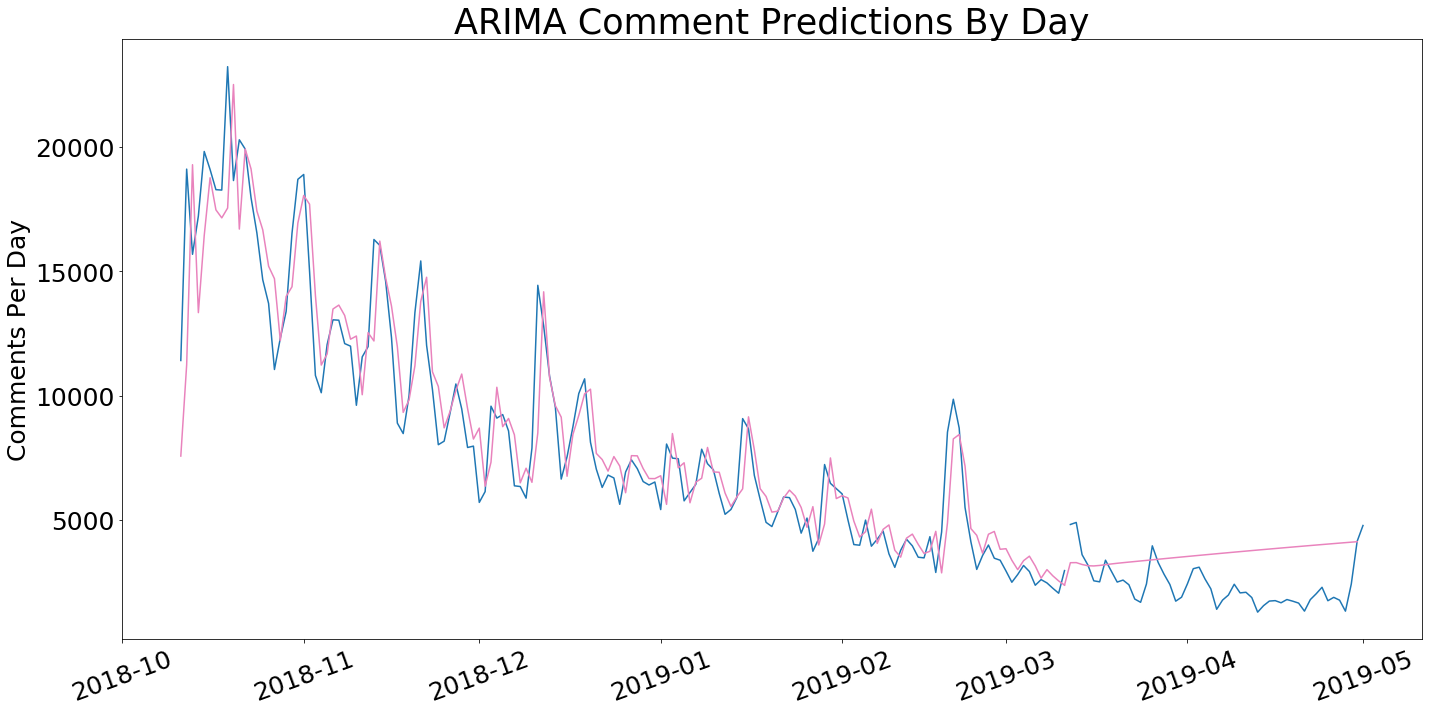

In [74]:
plt.figure(figsize = (20,10))
plt.plot(train_comment_count, color = 'C0')
plt.plot(preds_train_comment_count, color = '#E983BD')
plt.plot(test_comment_count, color = 'C0')
plt.plot(preds_test_comment_count, color = '#E983BD')
#plt.axhline(df_daily['count_comments'].mean())
plt.title('ARIMA Comment Predictions By Day', fontsize = 35)
plt.xticks(fontsize = 25, rotation = 20)
plt.yticks(fontsize = 25)
plt.ylabel('Comments Per Day', fontsize = 25)
plt.tight_layout()
#plt.savefig('../plots/arima_2.png');

Looking at the graph, and having run the dicky fuller test, it appears that the comments per day is stationary, which makes sense. Looking at the graph, even though the number of comments decreases, the trend follows a distinct pattern. The model trained pretty well, and actually predicted an upward trend, which probably won't happen, but it is a reminder that it isn't simply predicting the mean. It is approaching the mean, but it doesn't quite reach it. Since we don't know what happens after 2019-05, we can't say if the model predicting a new trend based in reality. If that curve was inverted, showing a downward trend, I would invest in this model. Over time, the comments will decrease as users decrease. We will look the user churn in a later notebook. 

## ARIMA User Predictions

In [75]:
train_authors = df_daily['unique_authors'].iloc[0:152]
test_authors  = df_daily['unique_authors'].iloc[152:]

For my user predictins, I found that 3 0 2 model works best, so I will be examining the predictions with that. 

In [76]:
model = ARIMA(endog = train_authors,
              order = (3,0,2))
arima_3_0_2 = model.fit()

preds_train_authors = arima_3_0_2.predict(start = 0, end = 151)
preds_test_authors  = arima_3_0_2.predict(start = 151, end = 201)

/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarni

In [77]:
print('Train RMSE: ', mean_squared_error(train_authors, preds_train_authors)**(1/2))
print('Test RMSE: ', mean_squared_error(test_authors, preds_test_authors)**(1/2))
print('Mean RMSE: ', mean_squared_error(test_authors, [df_daily['unique_authors'].mean() for i in range(len(test_compound))])**(1/2))

Train RMSE:  709.367081419611
Test RMSE:  340.2055356010876
Mean RMSE:  1902.7618333470682


It looks like my training and testing RMSEs are much better than the RMSE from the mean. This suggests that the model is pretty good at predicting user drop off. We will take a look at the plot below to visualize. 

In [78]:
train_authors.index = pd.to_datetime(train_authors.index)

In [79]:
test_authors.index = pd.to_datetime(test_authors.index)

In [80]:
interpret_dftest(adfuller(df_daily['unique_authors']))

Test Statistic   -3.836244
p-value           0.002558
dtype: float64

As I suspected after seeing the RMSE on my model, my unique authors data is stationary. We will be able to examine how well it predicts below in the graph. 

In [81]:
df_daily['unique_authors'].mean()

2982.84236453202

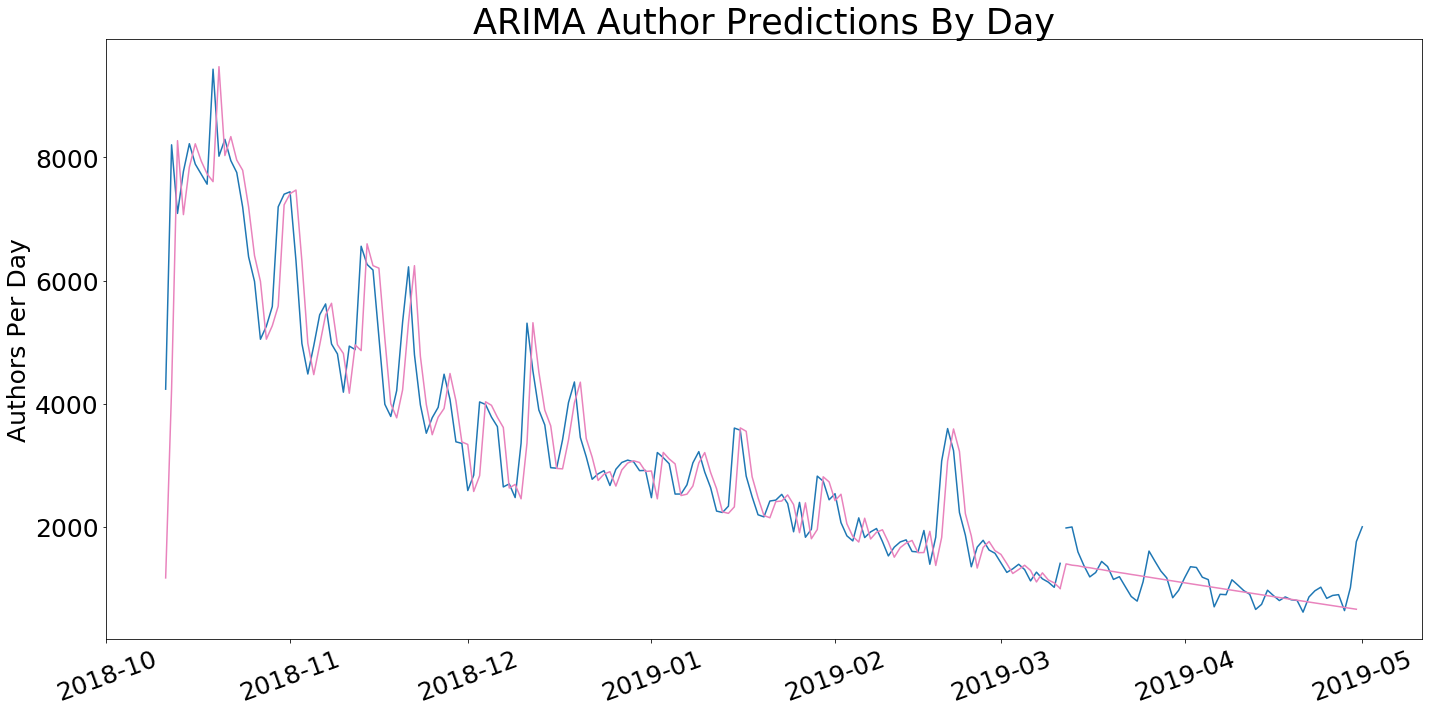

In [82]:
plt.figure(figsize = (20,10))
plt.plot(train_authors, color = 'C0')
plt.plot(preds_train_authors, color = '#E983BD')
plt.plot(test_authors, color = 'C0')
plt.plot(preds_test_authors, color = '#E983BD')
#plt.axhline(df_daily['count_comments'].mean())
plt.title('ARIMA Author Predictions By Day', fontsize = 35)
plt.xticks(fontsize = 25, rotation = 20)
plt.yticks(fontsize = 25)
plt.ylabel('Authors Per Day', fontsize = 25)
plt.tight_layout()
plt.savefig('../plots/arime_predictions_users');

The number of unique authors, as we saw by the dicky fuller test, is stationary. Looking at the plot above, we can see that there is a clear user dropoff over time. With less users, there are less comments and less participation. Our model continues predicting a downward trend, dispite the most recent spike in users, which could have been caused by a patch release. We will look at churn in another notebook and examine how long users participate in discussions about the game. It is interesting looking at this plot because it shows that despite patch releases, which are meant to 1. fix the game and 2. revitalize the game, don't have a lasting effect on participation. 

# Conclusion and Next Steps

Based on the arima models above, we can see that time series predictions on singular features can be quite difficult, regardless of stationarity.  In the each plot, except for the users one, we can see that the predictions don't quite line up with the validation set. The models seem to instinctually want to predict the mean, and try to converge on that point in the testing sets. With such polar spikes on a regular basis, I can see why the ARIMA model is having trouble with this data. The sentiment flunctuates constantly, with no apparent trend. The comments have a downward trend, but the model still wants to predict the mean. Lastly, the user dropoff has a downward trend, and the model predicts a continued downward trend. 

This suggests to me that despite patches, updates, and fixes, the game will continue to decline in popularity, so predicting when patches should be released based on sentiment may be a futile effort. We will look at how well a neural network can predict patch dates in the next notebook. If the model can predict patches well, then the sentiment may indeed be a useful feature to examine in the future. 

In regards to user dropoff, we will explore churn through survival analysis in the final notebook.